## Create the environment, the buffer and the VAE

Create environment.

In [1]:
import gym

env = gym.make("PrivateEye-v4")

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


Create a buffer and feed it.

In [2]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer

buffer = ReplayBuffer(10000, env.observation_space, env.action_space)

for episode in range(10):
    done = False
    obs = env.reset()
    while not done:
        action = np.array(env.action_space.sample())
        next_obs, reward, done, info = env.step(action)
        buffer.add(obs, next_obs, action, reward, done, [info])
        obs = next_obs

/Users/quentingallouedec/go-explore/env/lib/python3.8/site-packages/stable_baselines3/common/buffers.py:220: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.02GB > 1.68GB
  warnings.warn(


Create a categorical VAE.

In [3]:
from go_explore.categorical_vae import CategoricalVAE

device = "cpu"
vae = CategoricalVAE().to(device)

## Try the VAE

Sample a batch of observations.

In [4]:
input = buffer.sample(10).observations

Transpose, resize and psuh to the device.

In [5]:
from torchvision.transforms.functional import resize

input = input.moveaxis(-1, -3)
input = resize(input, (129, 129)).float() / 255
input = input.to(device)

Build the reconstruction.

In [6]:
recons, logits = vae(input)

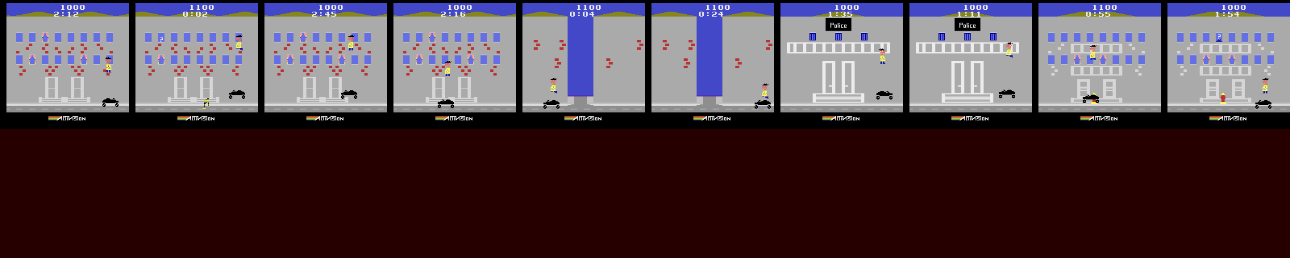

In [7]:
from go_explore.utils import build_recons_image

build_recons_image(input, recons)

Create the loss function.

In [8]:
import torch
import torch.nn.functional as F


def loss_func(input: torch.Tensor, recons: torch.Tensor, logits: torch.Tensor) -> torch.Tensor:
    # Reconstruction loss
    recons_loss = F.mse_loss(input, recons)

    # KL loss
    nb_classes = logits.shape[2]
    probs = F.softmax(logits, dim=2)
    latent_entropy = probs * torch.log(probs + 1e-10)
    target_entropy = probs * torch.log((1.0 / torch.tensor(nb_classes)))
    kl_loss = (latent_entropy - target_entropy).mean()

    # Total loss
    loss = recons_loss + 0.01 * kl_loss
    return loss, recons_loss, kl_loss


Test the loss function.

In [9]:
print(loss_func(input, recons, logits))

(tensor(0.4394, grad_fn=<AddBackward0>), tensor(0.4394, grad_fn=<MseLossBackward0>), tensor(1.7696e-06, grad_fn=<MeanBackward0>))


In [10]:
from torch import optim

buffer_size = 64
optimizer = optim.Adam(vae.parameters(), lr=2e-4)

for epoch in range(5000):
    input = buffer.sample(10).observations
    input = input.moveaxis(-1, -3)
    input = resize(input, (129, 129)).float() / 255
    input = input.to(device)
    recons, logits = vae(input)
    loss, recons_loss, kl_loss = loss_func(input, recons, logits)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(
            "epoch: {:5d}\tloss: {:.5f}\trecons error: {:.5f}\tkl loss: {:.5f}".format(
                epoch, loss.item(), recons_loss.item(), kl_loss.item()
            ),
        )


epoch:     0	loss: 0.44337	recons error: 0.44337	kl loss: 0.00000
epoch:   500	loss: 0.01824	recons error: 0.01799	kl loss: 0.02480
epoch:  1000	loss: 0.01041	recons error: 0.01023	kl loss: 0.01810
epoch:  1500	loss: 0.00802	recons error: 0.00784	kl loss: 0.01745
epoch:  2000	loss: 0.00667	recons error: 0.00653	kl loss: 0.01392
epoch:  2500	loss: 0.00603	recons error: 0.00589	kl loss: 0.01411
epoch:  3000	loss: 0.00531	recons error: 0.00513	kl loss: 0.01746
epoch:  3500	loss: 0.00463	recons error: 0.00443	kl loss: 0.02053
epoch:  4000	loss: 0.00525	recons error: 0.00506	kl loss: 0.01984
epoch:  4500	loss: 0.00395	recons error: 0.00373	kl loss: 0.02204


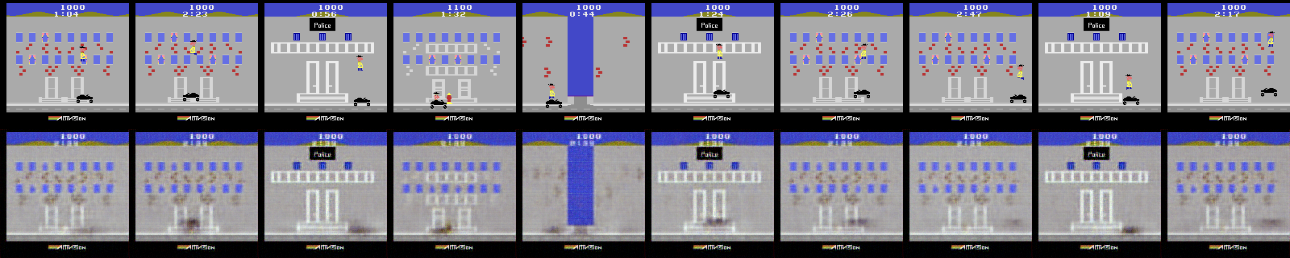

In [12]:
input = buffer.sample(10).observations
input = input.moveaxis(-1, -3)
input = resize(input, (129, 129)).float() / 255
input = input.to(device)
recons, logits = vae(input)
build_recons_image(input, recons)